In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading data

In [3]:
df_full = pd.read_csv('pirvision_full.csv')
df_test = pd.read_csv('pirvision_office_test.csv')
df_train = pd.read_csv('pirvision_office_train.csv')
df = pd.read_csv('pirvision_full.csv')
target = 'Class'

# Analyze

### Analyzing numeric atributes

          Day Index      Temp (F)      Temp (C)         OBS_1         OBS_2  \
count  10000.000000  10000.000000  10000.000000  9.000000e+03  10000.000000   
mean       2.005500     80.392600     26.698500  2.938913e+05  10962.186600   
std        0.524306     22.858463     12.423254  4.662186e+06   1363.587937   
min        1.000000      0.000000    -17.000000  2.613000e+03   2092.000000   
25%        2.000000     86.000000     30.000000  1.033500e+04  10779.000000   
50%        2.000000     86.000000     30.000000  1.043300e+04  11001.000000   
75%        2.000000     88.000000     31.000000  1.056425e+04  11281.000000   
max        3.000000     89.000000     31.000000  1.116026e+08  16928.000000   

              OBS_3        OBS_4         OBS_5         OBS_6         OBS_7  \
count  10000.000000  10000.00000  10000.000000  10000.000000  10000.000000   
mean   11521.633700  11583.09270  11273.430600  10799.281200  10315.357700   
std      669.185253    673.74107    617.612601    550.

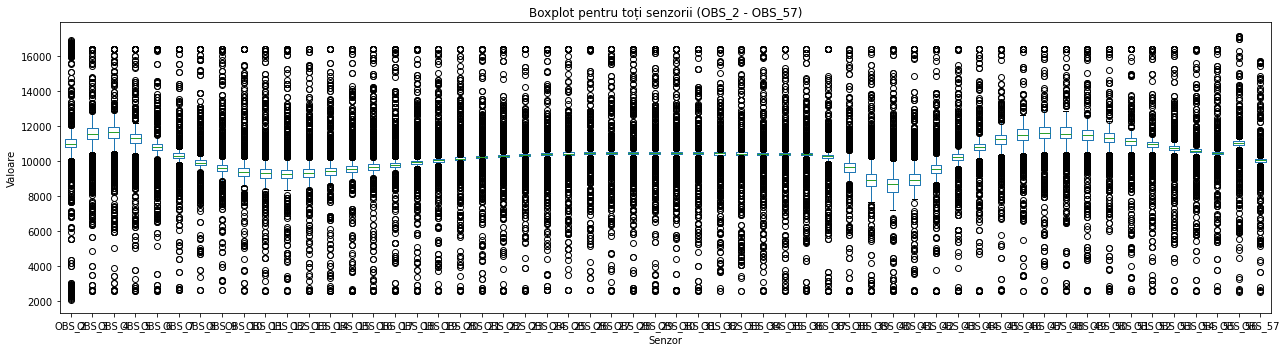

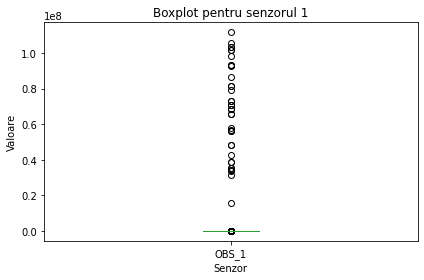

In [4]:
numeric_cols = df.select_dtypes(include='number').drop(columns='Class').columns

numeric_data = df[numeric_cols].describe()
print(numeric_data)

# Selectează toate coloanele de tip senzor
senzori_cols = [col for col in df.columns if col.startswith('OBS_') and col != 'OBS_1']

# Creează un singur boxplot pentru toți senzorii
plt.figure(figsize=(18, 5))
df[senzori_cols].boxplot()
plt.title('Boxplot pentru toți senzorii (OBS_2 - OBS_57)')
plt.xlabel('Senzor')
plt.ylabel('Valoare')
plt.grid(False)
plt.tight_layout()
plt.show()

senzor_1 = [col for col in df.columns if col in 'OBS_1']

# Creează un singur boxplot pentru toți senzorii
df[senzor_1].boxplot()
plt.title('Boxplot pentru senzorul 1')
plt.xlabel('Senzor')
plt.ylabel('Valoare')
plt.grid(False)
plt.tight_layout()
plt.show()

### Analyzing discret/ordinary atributes

In [5]:
discret__ordinary_cols = [
    'Timestamp', 'Day'
]

print(f"Number of example with no NaN values: {len(df[discret__ordinary_cols].dropna())}\n")

nunique_vals = df[discret__ordinary_cols].nunique()
print(f"Number of unique values:\n{nunique_vals}")

Number of example with no NaN values: 8094

Number of unique values:
Timestamp    5502
Day             3
dtype: int64


### Analyzing balance of classes

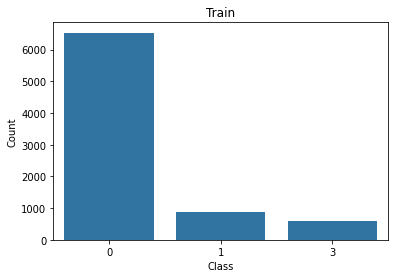

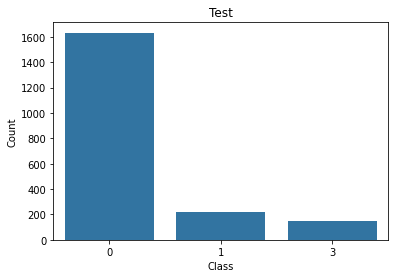

In [6]:
import seaborn as sns

sns.countplot(x=target, data=df_train)
plt.title('Train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

sns.countplot(x=target, data=df_test)
plt.title('Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


### Analyzing corelation between atributes

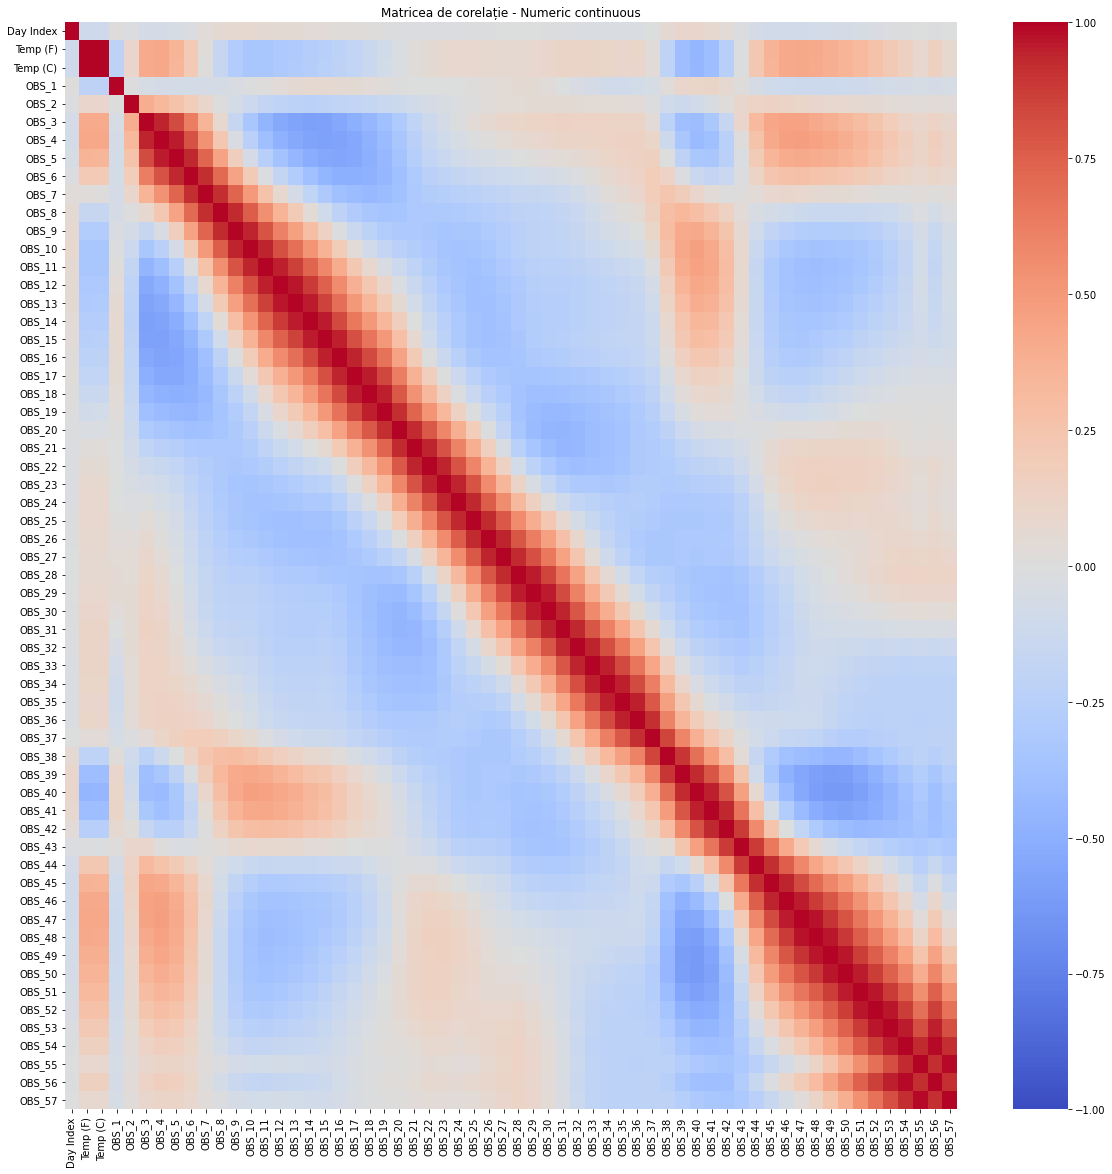

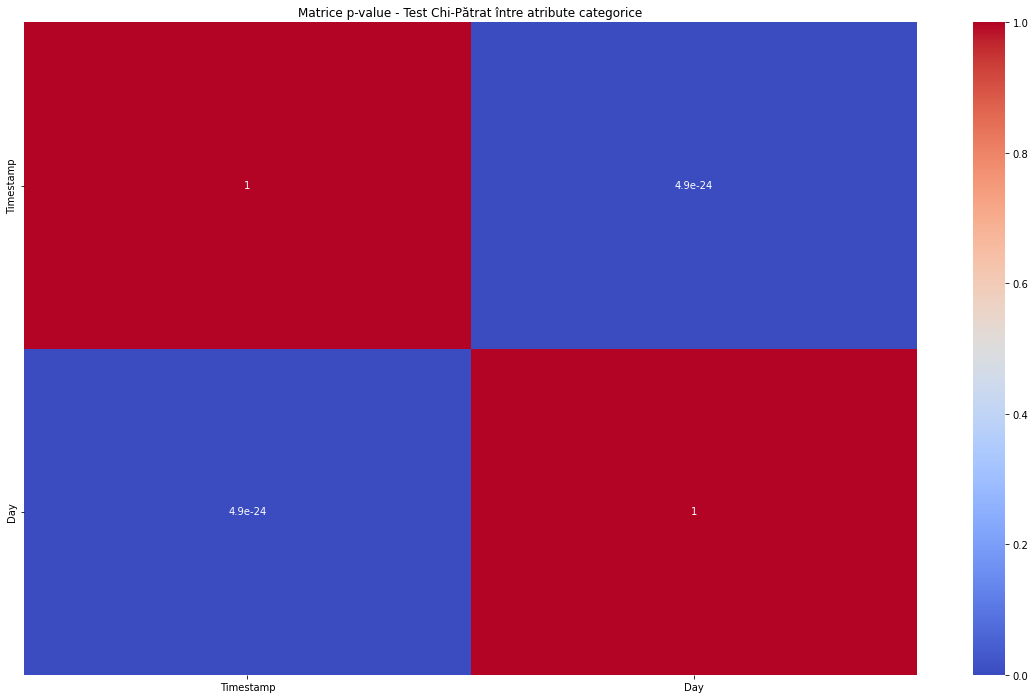

In [7]:
# Between numerical atributes
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matricea de corelație - Numeric continuous')
plt.xticks(rotation=90)
plt.show()

# Between categorical atributes
from scipy.stats import chi2_contingency
categorical_cols = discret__ordinary_cols

# Creează o matrice pătrată cu NaN inițial
pval_matrix = pd.DataFrame(np.ones((len(categorical_cols), len(categorical_cols))),
                          index=categorical_cols, columns=categorical_cols)

for i in range(len(categorical_cols)):
    for j in range(i+1, len(categorical_cols)):
        col1 = categorical_cols[i]
        col2 = categorical_cols[j]
        contingency_table = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        pval_matrix.loc[col1, col2] = p
        pval_matrix.loc[col2, col1] = p

# Pe diagonală pune 0 (p=0, perfect corelate cu ele însele)
np.fill_diagonal(pval_matrix.values, 1)

plt.figure(figsize=(20, 12))
sns.heatmap(pval_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Matrice p-value - Test Chi-Pătrat între atribute categorice')
plt.show()

# Preprocesing

Dropping corelated atributes and printing atributes with missing data

In [8]:
missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))

Atribute cu valori lipsă: ['Timestamp', 'Day', 'OBS_1']


### Imputing values

In [9]:
from sklearn.linear_model import LinearRegression


# 1. Selectează rândurile fără NaN la OBS_1 și fără NaN la OBS_3, OBS_4, OBS_5
mask_train = df['OBS_1'].notna() & df['OBS_2'].notna() & df['OBS_3'].notna() & df['OBS_4'].notna()
X_train = df.loc[mask_train, ['OBS_2', 'OBS_3', 'OBS_4']]
y_train = df.loc[mask_train, 'OBS_1']

# 2. Antrenează modelul
model = LinearRegression()
model.fit(X_train, y_train)

# 3. Selectează rândurile UNDE OBS_1 este NaN dar ceilalți există
mask_pred = df['OBS_1'].isna() & df['OBS_2'].notna() & df['OBS_3'].notna() & df['OBS_4'].notna()
X_pred = df.loc[mask_pred, ['OBS_2', 'OBS_3', 'OBS_4']]

# 4. Completează valorile lipsă
df.loc[mask_pred, 'OBS_1'] = model.predict(X_pred)

### Reduntant atributes


In [10]:
# Selectăm doar o singură dată fiecare pereche (triunghiul superior fără diagonală)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Eliminăm senzorii care au corelație mai mare de 0.95 cu alt senzor
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df.drop(columns=to_drop, inplace=True)
numeric_cols = [col for col in numeric_cols if col not in to_drop]
print(f"Senzori rămași: {len([col for col in df.columns if col.startswith('OBS_')])}")

# elimnare day timestamp, Day , Day Index
df.drop(columns=['Day','Timestamp', 'Day Index'], inplace=True)
numeric_cols = [col for col in numeric_cols if col not in ['Day Index']]
missing_cols = df.columns[df.isna().any()]
print("Atribute cu valori lipsă:", list(missing_cols))

Senzori rămași: 36
Atribute cu valori lipsă: []


### remove of extreme values

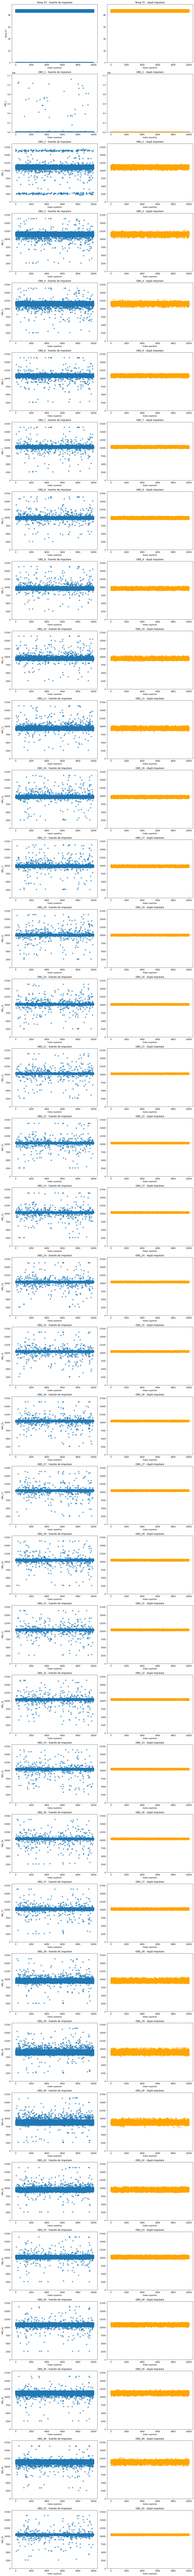

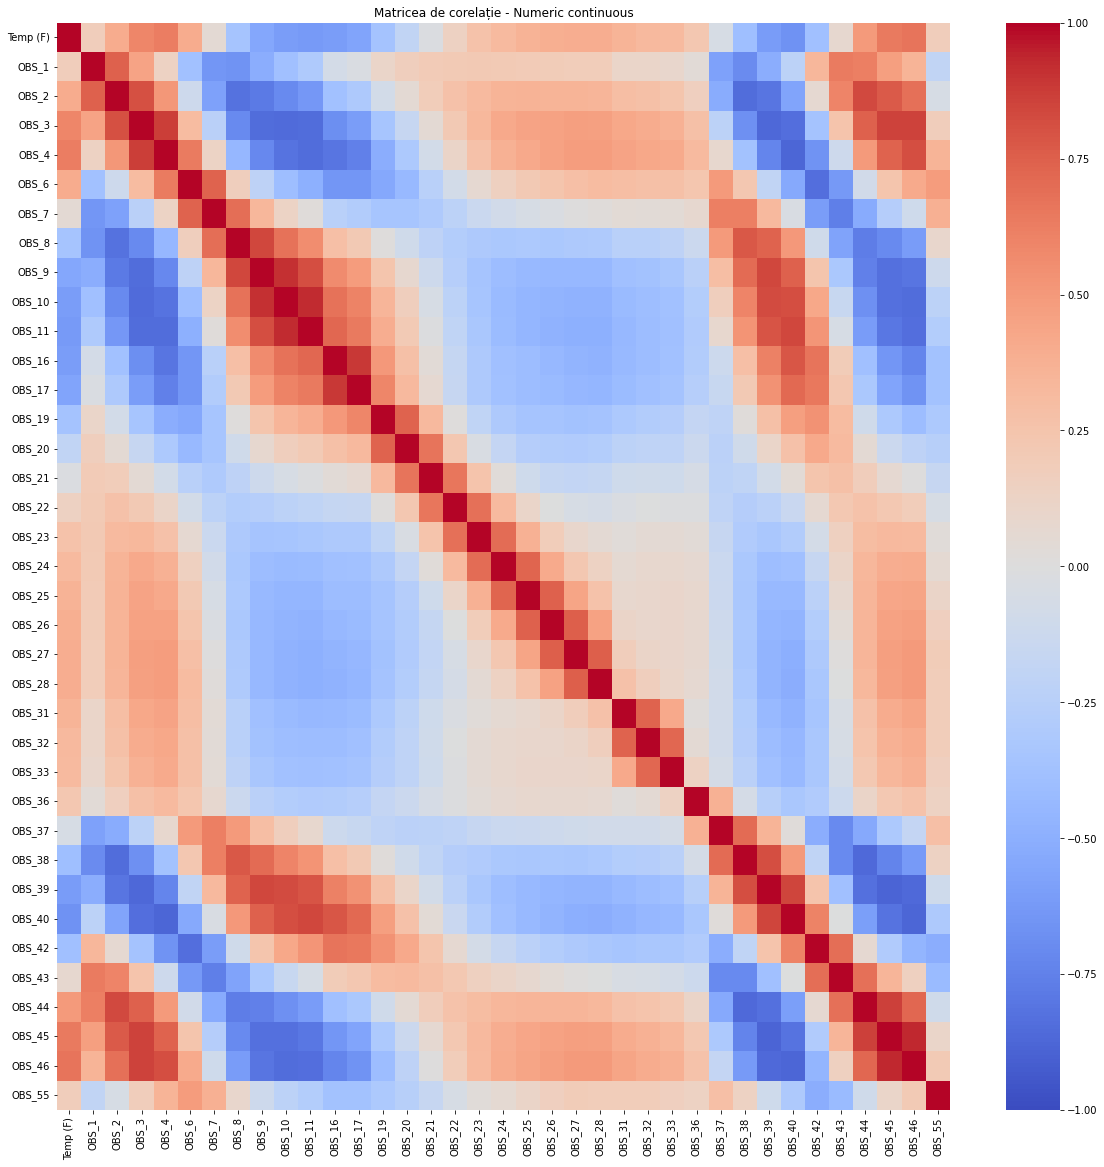

In [11]:
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
cols = [col for col in df.columns if col.startswith('Temp') or col.startswith('OBS_')]

imputer = SimpleImputer(strategy='mean')
df_copy = df[cols].copy()
plt.figure(figsize=(14, len(cols)*5))  # înălțime variabilă după număr coloane

for i, col in enumerate(cols):
    # Detectare IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Pregătim subplot pentru coloana curentă - 2 coloane (înainte și după)
    plt.subplot(len(cols), 2, 2*i + 1)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6)
    plt.title(f'{col} - înainte de imputare')
    plt.xlabel('Index eșantion')
    plt.ylabel(col)
    plt.ylim(0, 1.1 * df_copy[col].max())  # scale uniformă aproximativ

    # Setăm valorile extreme ca NaN în copia pentru imputare
    mask_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    df.loc[mask_outliers, col] = np.nan

    # Imputăm valorile lipsă (inclusiv extremele)
    df[col] = imputer.fit_transform(df[[col]])

    plt.subplot(len(cols), 2, 2*i + 2)
    plt.scatter(range(len(df[col])), df[col], alpha=0.6, color='orange')
    plt.title(f'{col} - după imputare')
    plt.xlabel('Index eșantion')
    plt.ylim(0, 1.1 * df_copy[col].max())

plt.tight_layout()
plt.show()

corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matricea de corelație - Numeric continuous')
plt.xticks(rotation=90)
plt.show()


### Standardization


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Extragem doar coloanele numerice
X_numeric = df[numeric_cols]

# Aplicăm scalarea
X_scaled = scaler.fit_transform(X_numeric)

# Dacă vrei să păstrezi într-un DataFrame cu aceleași nume de coloane:
df[numeric_cols] = X_scaled

# Verificăm media și deviația standard după scalare
print(f'Media pe coloane după scalare:\n{df[numeric_cols].mean(axis=0)}\n')
print(f'Deviația standard pe coloane după scalare:\n{df[numeric_cols].std(axis=0)}\n')


Media pe coloane după scalare:
Temp (F)    1.933209e-15
OBS_1       7.290168e-16
OBS_2       3.598544e-15
OBS_3       1.957190e-15
OBS_4       9.844570e-16
OBS_6       1.328715e-16
OBS_7       2.928857e-15
OBS_8       1.044498e-15
OBS_9       7.120793e-15
OBS_10      1.313794e-15
OBS_11     -1.903544e-15
OBS_16     -1.440448e-15
OBS_17      6.571810e-15
OBS_19      8.842704e-16
OBS_20     -1.134062e-14
OBS_21     -9.376322e-15
OBS_22      6.753709e-16
OBS_23      7.069900e-15
OBS_24     -1.322071e-14
OBS_25      7.651835e-15
OBS_26     -1.282423e-14
OBS_27     -2.518945e-14
OBS_28      1.720224e-14
OBS_31     -2.923883e-16
OBS_32      2.832312e-15
OBS_33      1.444427e-14
OBS_36      2.443556e-14
OBS_37     -2.019362e-15
OBS_38      6.280487e-15
OBS_39      2.320277e-15
OBS_40      2.699352e-15
OBS_42     -6.139089e-15
OBS_43     -2.012612e-15
OBS_44     -6.617462e-15
OBS_45      2.170353e-15
OBS_46     -5.713119e-15
OBS_55      1.333049e-14
dtype: float64

Deviația standard pe coloane

## Decision TREE

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier  # or RandomForestClassifier
from sklearn.model_selection import train_test_split
target = 'Class'
model = DecisionTreeClassifier(class_weight='balanced', random_state=123)
X = df.drop(columns=[target])  # variabilele de intrare
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_macro',  # or 'accuracy', 'recall_macro', etc.
    n_jobs=-1,  # use all CPU cores
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (CV):", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1}
Best Score (CV): 0.9877321636208926


Confusion Matrix:
[[1609   17    0]
 [   6  218    0]
 [   0    0  150]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1626
           1       0.93      0.97      0.95       224
           3       1.00      1.00      1.00       150

    accuracy                           0.99      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       0.99      0.99      0.99      2000


Accuracy: 0.9885


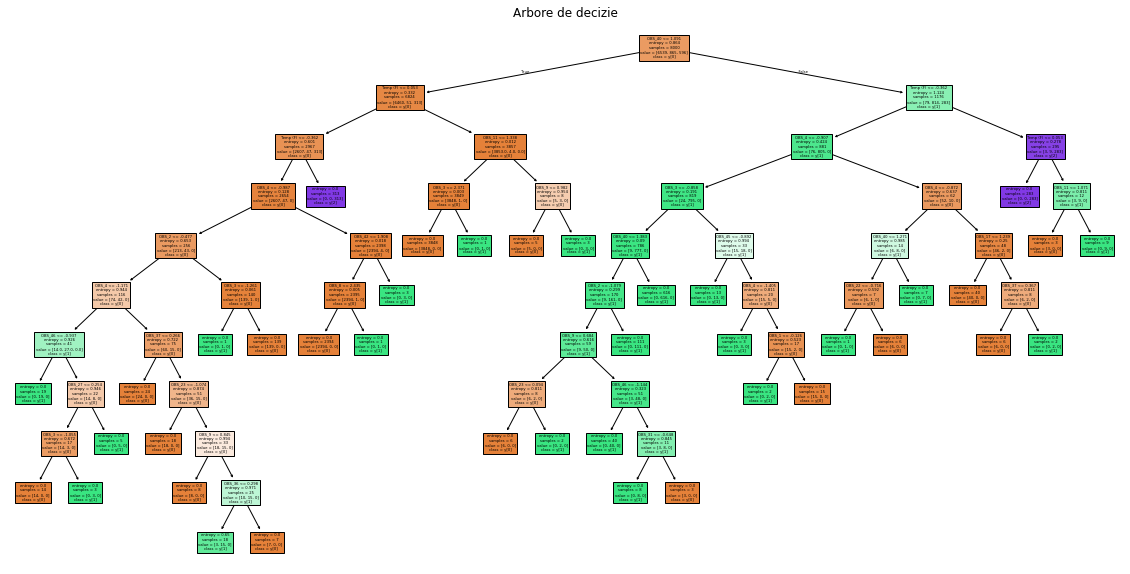

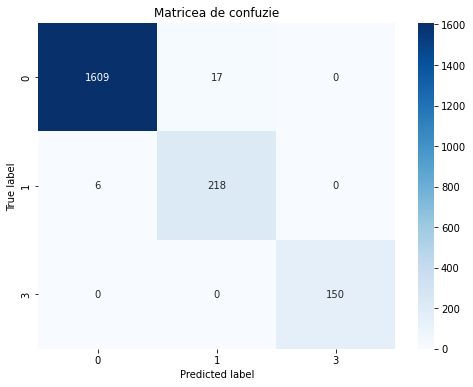

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = df.drop(columns=[target])  # variabilele de intrare
y = df[target]                 # eticheta

# Împărțim în set de antrenare și test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
model = DecisionTreeClassifier(criterion='entropy', max_depth= 10, min_samples_leaf=1, random_state=123)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=True, filled=True)
plt.title("Arbore de decizie")
plt.show()
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()


## Random Forest

Confusion Matrix:
[[1630    3    0]
 [  12  205    1]
 [   3    0  146]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9909    0.9982    0.9945      1633
           1     0.9856    0.9404    0.9624       218
           3     0.9932    0.9799    0.9865       149

    accuracy                         0.9905      2000
   macro avg     0.9899    0.9728    0.9811      2000
weighted avg     0.9905    0.9905    0.9904      2000


Accuracy: 0.9905


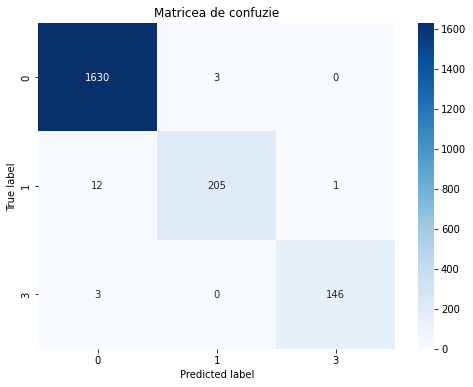

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Să presupunem că ai deja datele într-un DataFrame df
# Coloana țintă este 'chd_risk'
X = df.drop(columns=[target])  # variabilele de intrare
y = df[target]  

# Împărțire train/test (de exemplu 80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

# Creare model Random Forest cu ponderi pentru clase (pentru a compensa dezechilibrul)
model = RandomForestClassifier(class_weight='balanced', random_state=123)
model.fit(X_train, y_train)

# Predicții
y_pred = model.predict(X_test)

# Evaluare
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()

## Logistic Regression

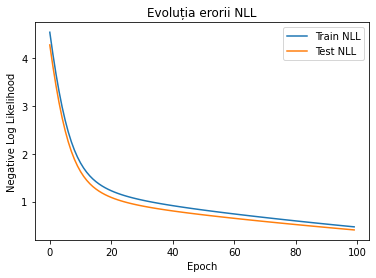

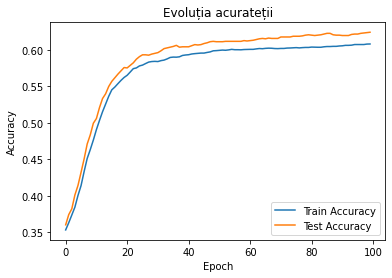

Acuratețe finală pe train: 0.6084
Acuratețe finală pe test: 0.6245


In [16]:
# TODO <1>: Implementati functia de sigmoida logistica
def logistic(x):
    return 1 / (1 + np.exp(-x))

# TODO <2.1>: Implementati expresia pentru Negative Log Likelihood - functia J(w), unde Y este predictia data de modelul logistic, 
# iar T sunt etichetele de clasa pentru cele N exemple din setul de date
def nll(Y, T):
    N = T.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de Negative Log Likelihood
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca T poate fi 0 sau 1
    return (-1 / N) * (T @ np.log(Y) + (1 - T) @ np.log(1 - Y))

# TODO <2.2>: Implementati expresia care intoarce acuratetea clasificarii
def accuracy(Y, T):
    N = Y.shape[0]

    # TODO: Inlocuiti aici cu expresia functiei de acuratete
    # Hint: folositi notiunea de indexare logica din numpy si faptul ca 
    #       in numpy True este echivalent cu 1 si False cu 0
    Y_pred = Y >= 0.5
    return np.sum(Y_pred == T) / N

def predict_logistic(X, w):
    # TODO <3.1> : Calculati predictia Y a modelului logistic antrenat (ponderile w invatate)
    # Hint: urmariti explicatiile de utilizare ale functiei `numpy.dot` pentru a putea calcula 
    # produsele scalare intre toti vectorii x^(i) si ponderile w intr-un singur apel
    N = X.shape[0]
    return logistic(X @ w)
def train_and_eval_logistic(X_train, T_train, X_test, T_test, lr=.01, epochs_no=100):
    # TODO <3.2> : Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
    (N, D) = X.shape
    
    # Initializare ponderi
    np.random.seed(123)
    w = np.random.randn(D)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []

    for epoch in range(epochs_no):
        # 1. Obtineti Y_train si Y_test folosind functia predict_logistic
        Y_train = predict_logistic(X_train, w)
        Y_test  = predict_logistic(X_test, w)
        # 2. Adaugati acuratetea si negative log likelihood-ul pentru setul de antrenare si de testare 
        #    la fiecare pas; utilizati functiile accuracy si nll definite anterior
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        # 3. Actualizati ponderile w folosind regula de actualizare a gradientului
        w -= (lr / N) * np.dot(X_train.T, (Y_train - T_train))    

    return w, train_nll, test_nll, train_acc, test_acc

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# Exemplu: presupunem ca X_train, T_train, X_test, T_test sunt deja definite

# Antrenare și evaluare logistic regression
w, train_nll, test_nll, train_acc, test_acc = train_and_eval_logistic(
    X_train, y_train, X_test, y_test, lr=0.1, epochs_no=100
)

# Afișează evoluția erorii și a acurateții
import matplotlib.pyplot as plt

plt.plot(train_nll, label='Train NLL')
plt.plot(test_nll, label='Test NLL')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Evoluția erorii NLL')
plt.show()

plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Evoluția acurateții')
plt.show()

# Afișează acuratețea finală
print(f"Acuratețe finală pe train: {train_acc[-1]:.4f}")
print(f"Acuratețe finală pe test: {test_acc[-1]:.4f}")

## Multi-Layered perceptron


Confusion Matrix:
[[1628    4    1]
 [  13  202    3]
 [  11    0  138]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9855    0.9969    0.9912      1633
           1     0.9806    0.9266    0.9528       218
           3     0.9718    0.9262    0.9485       149

    accuracy                         0.9840      2000
   macro avg     0.9793    0.9499    0.9642      2000
weighted avg     0.9839    0.9840    0.9838      2000


Accuracy: 0.9840


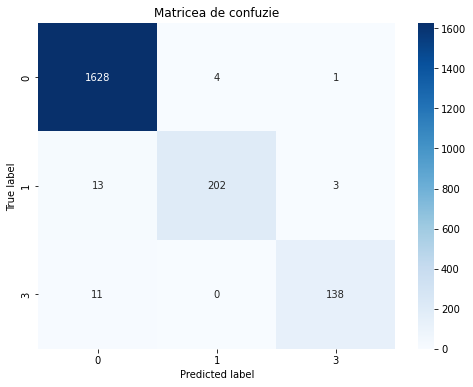

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=[target])  # variabilele de intrare
y = df[target]  

# Împărțire train/test (de exemplu 80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

# Creare model Random Forest cu ponderi pentru clase (pentru a compensa dezechilibrul)
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=123)
model.fit(X_train, y_train)

# Predicții
y_pred = model.predict(X_test)

# Evaluare
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matricea de confuzie')
plt.show()